# Age and Experience Plots

In [250]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.legend_handler import HandlerTuple
from matplotlib.legend_handler import HandlerBase
from PIL import Image


# path to TEMP folder
temp_folder = os.path.join(os.getcwd(), '..', 'TEMP')
# Data folder
data_folder = os.path.join(os.getcwd(), '..', 'data')
# Image folder
img_folder = os.path.join(os.getcwd(), '..', 'images')
# Logo folder
logo_folder = os.path.join(os.getcwd(), '..', 'images', 'logos')


################################################################################
roster_file = os.path.join(data_folder, 'roster_2024_current_v2.csv') # PATH TO THE ROSTER FILE
roster_df = pd.read_csv(roster_file) # read as dataframe

# Path to school info table (csv)
school_info_file = os.path.join(data_folder, 'arena_school_info.csv')
school_info_df = pd.read_csv(school_info_file)

# print(roster_df.columns)

### Dictionaries and Constants

In [251]:
## Conference Membership

atlantic = ['Air Force', "American Intl", 'Army', 'Bentley', 'Canisius', 'Holy Cross', 'Mercyhurst', 
            'Niagara', 'RIT', 'Robert Morris', 'Sacred Heart', 'St Lawrence']

big_ten = ['Michigan', 'Michigan State', 'Minnesota', 'Notre Dame', 'Ohio State', 'Penn State', 'Wisconsin']

ccha = ['Augustana', 'Bemidji State', 'Bowling Green', 'Ferris State', 'Lake Superior', 'Michigan Tech', 
        'Minnesota State', 'Northern Michigan', 'St Thomas']

ecac = ['Brown', 'Clarkson', 'Colgate', 'Cornell', 'Dartmouth', 'Harvard', 'Princeton', 'Quinnipiac',
        'Rensselaer', 'St Lawrence', 'Union', 'Yale']

hockey_east = ['Boston College', 'Boston University', 'Connecticut', 'Maine', 'Massachusetts', 'Mass Lowell',
                'Merrimack', 'New Hampshire', 'Northeastern', 'Providence', 'Vermont']

nchc = ['Arizona State', 'Colorado College', 'Denver', 'Miami', 'Minnesota Duluth', 'North Dakota', 'Omaha', 'St Cloud State',
        'Western Michigan']

independents = ['Alaska Anchorage', 'Alaska', 'Lindenwood', 'Long Island', 'Stonehill']

# Create a dictionary of {Team: logo_abv} for each team with .png added to the end
logo_mapping = {}

for index, row in school_info_df.iterrows():
    logo_mapping[row['Team']] = row['logo_abv'] + '.png'

# print(logo_mapping)

### Data Modifications

In [252]:
# Convert DOB to datetime
roster_df['DOB'] = pd.to_datetime(roster_df['DOB'], errors='coerce')

# Calculate Player age from DOB (Using season start Oct 1, 2024)
roster_df['Age'] = (pd.Timestamp('2024-10-01') - roster_df['DOB']).apply(lambda x: x.days / 365.25)

# Rename Current Team to Team
roster_df.rename(columns={'Current Team': 'Team'}, inplace=True)

## Caclulate the average age of each team
team_avg_age = roster_df.groupby('Team')['Age'].mean().reset_index()


### Calculate Roster Makeup by Class 

In [253]:
# Get a count of each class rank by team

# Create a pivot table of the class rank count
class_rank_count = roster_df.pivot_table(index='Team', columns='Yr', values='Last_Name', aggfunc='count', fill_value=0).reset_index()

# Calculate the total number of players on each team
class_rank_count['Total'] = class_rank_count['Fr'] + class_rank_count['So'] + class_rank_count['Jr'] + class_rank_count['Sr'] + class_rank_count['Gr']

# # Reorder the columns
# class_rank_count = class_rank_count[['Season', 'Current Team', 'Fr', 'So', 'Jr', 'Sr', 'Gr', 'Total']]
# # Convert the columns to int (0 for Nan)
# class_rank_count[['Fr', 'So', 'Jr', 'Sr', 'Gr', 'Total']] = class_rank_count[['Fr', 'So', 'Jr', 'Sr', 'Gr', 'Total']].fillna(0).astype(int)

## Add the average age to the class_rank_count
class_rank_count = class_rank_count.merge(team_avg_age, on='Team', how='left')


# Calculate the percentage of each class rank
class_rank_count['Fr%'] = class_rank_count['Fr'] / class_rank_count['Total']
class_rank_count['So%'] = class_rank_count['So'] / class_rank_count['Total']
class_rank_count['Jr%'] = class_rank_count['Jr'] / class_rank_count['Total']
class_rank_count['Sr%'] = class_rank_count['Sr'] / class_rank_count['Total']
class_rank_count['Gr%'] = class_rank_count['Gr'] / class_rank_count['Total']

# Reorder Columns
class_rank_count = class_rank_count[['Team', 'Age', 'Fr', 'Fr%', 'So', 'So%', 'Jr', 'Jr%', 'Sr', 'Sr%', 'Gr', 'Gr%', 'Total']]

# class_rank_count.tail(10)

In [254]:
class_rank_count.head()

,Team,Age,Fr,Fr%,So,So%,Jr,Jr%,Sr,Sr%,Gr,Gr%,Total
0,Air Force,22.072724,12,0.375000,10,0.312500,4,0.125000,6,0.187500,0,0.000000,32
1,Alaska,22.657175,13,0.419355,4,0.129032,6,0.193548,5,0.161290,3,0.096774,31
2,Alaska Anchorage,22.503569,10,0.344828,6,0.206897,7,0.241379,4,0.137931,2,0.068966,29
3,American Intl,22.417434,8,0.242424,7,0.212121,8,0.242424,7,0.212121,3,0.090909,33
4,Arizona State,21.923431,6,0.193548,9,0.290323,5,0.161290,4,0.129032,7,0.225806,31


### Chart Style and Formatting Options

In [255]:
######## FONT STUFF ########
import matplotlib.font_manager as fm

# # Get the list of available fonts
# available_fonts = sorted([f.name for f in fm.fontManager.ttflist])

# # Display the list of fonts
# for font in available_fonts:
#     print(font)

# Path to your custom font file
custom_font_path = r'C:\Windows\Fonts\Exo 2'

# Load the custom font
custom_font = fm.FontProperties(fname=custom_font_path)

In [256]:
## Formatting constants
position_order = ['Forwards', 'Defensemen', 'Goaltenders'] # Set the order of the positions
class_order = ['Fr', 'So', 'Jr', 'Sr', 'Gr'] # Set the order of Class Rank

###### SETTINGS ######
zoom_factor = 0.25
y_offset = 1.1
age_offset = -.125
age_fontsize = 12
set_fig_size = '10, 10'

### Global Settings
set_linewidth = 1
all_color='lightgrey'




## FONT PARAMETERS
# font_path = 'C:/Windows/Fonts/Exo 2.tff'

font = custom_font

font_title_param = {f'family': {font}, 'color': 'black', 'weight': 'normal', 'size': 16}
font_label_param = {f'family': {font}, 'color': 'black', 'weight': 'normal', 'size': 14}
font_tick_param = {f'family': {font}, 'color': 'black', 'weight': 'normal', 'size': 8}
font_label_large_param = {'family': {font}, 'color': 'black', 'weight': 'normal', 'size': 16}
font_tick_large_param = {f'family': {font}, 'color': 'black', 'weight': 'normal', 'size': 12}

font_tag_parm = {f'family': 'CMU Sans Serif', 'color': 'black', 'weight': 'bold', 'size': 10}
font_tag_parm_2 = {f'family': {font}, 'color': 'black', 'weight': 'bold', 'size': 12}

### Functions

In [257]:
### Add Team Logos to the Plot
def add_logos_to_plot(data_df, x_col, y_col, logo_mapping, logo_folder, ax, teams_in_region):
    # Plot logos for specific teams
    for team in teams_in_region:
        team_data = data_df[data_df['Team'] == team]
        if not team_data.empty:
            x = team_data[x_col].values[0]
            y = team_data[y_col].values[0]
            logo_path = os.path.join(logo_folder, logo_mapping.get(team, ""))
            if logo_path:
                try:
                    logo_img = plt.imread(logo_path)
                    imagebox = OffsetImage(logo_img, zoom=0.15)  # Adjust zoom as needed
                    ab = AnnotationBbox(imagebox, (x, y), frameon=False, xybox=(10, 20), boxcoords="offset points", pad=0)
                    ax.add_artist(ab)  # Apply the ax here as the artist is being added to ax
                except Exception as e:
                    print(f"Error adding logo for {team}: {e}")



In [258]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import os

figure_size = (10, 10)

def plot_team_ages_and_experience_with_logos(df, team_names, region_name, conference_logo=None):
    """
    Plots a stacked bar chart comparing the age and experience of hockey teams, using team logos for x-axis labels.

    Parameters:
    - df: DataFrame containing team names, ages, and class proportions (Fr%, So%, Jr%, Sr%, Gr%).
    - team_names: List of the team names to be included in the plot.
    - region_name: The name of the region for the title of the plot.
    """
    
    # Filter the dataframe to include only the teams we want
    filtered_df = df[df['Team'].isin(team_names)]

    # Ensure team names match filtered dataframe
    valid_team_names = filtered_df['Team'].tolist()

    if len(valid_team_names) != len(team_names):
        print(f"Warning: Some teams in the input list are not in the dataframe. Using only valid teams: {valid_team_names}")
        team_names = valid_team_names
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=figure_size)
    
    # Set the title of the plot
    ax.set_title(f"Age and Experience:\n{region_name}", fontsize=20, weight='bold', pad = 25)
    
    # Set y-axis label
    # ax.set_ylabel("<---Least-------Proportion of Players-------Most--->", fontsize=16, weight='bold')
    ax.set_ylabel("<---Least-------------Experience-------------Most--->", fontsize=16, weight='bold')
    
    # Ensure the y-axis represents 100%
    ax.set_ylim([0, 1])  # This makes sure the y-axis is scaled from 0 to 100%
    
    # Remove x-tick labels
    ax.set_xticks(range(len(team_names)))
    ax.set_xticklabels([])  # Remove the x-tick labels
    
    # Set gridlines
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    
    # Define year positions and corresponding colors for the stacked bars
    year_labels = ['Fr%', 'So%', 'Jr%', 'Sr%', 'Gr%']
    colors = ['#40A4D8', '#FDE725', '#FCA636', '#F94144', '#6A4C93']

    # Loop over each year label (Fr%, So%, Jr%, Sr%, Gr%) and plot the proportions
    bottom_values = [0] * len(team_names)
    for i, year in enumerate(year_labels):
        proportions = filtered_df[year].values
        
        # Plot the stacked bars for each class year
        bars = ax.bar(range(len(team_names)), proportions, bottom=bottom_values, color=colors[i], label=year)
        
        # Update bottom values to stack the next year's bars
        bottom_values = [x + y for x, y in zip(bottom_values, proportions)]
        
        # Add text annotations for each bar with bold font
        for bar in bars:
            height = bar.get_height()
            if height > 0:  # Only add text for non-zero heights
                ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2, f'{height:.1%}',
                        ha='center', va='center', fontsize=12, weight='bold', color='black')
    

        # Now add the average age above each bar
    avg_ages = filtered_df['Age'].values
    for i, age in enumerate(avg_ages):
        # Position the average age text slightly above the tallest stacked bar
        ax.text(i, 1.015, f'{age:.2f}', ha='center', va='center', fontsize=12, 
        color='black', fontstyle = 'italic')

    # Add "Average Age" label just above the average age numbers
    fig.text(0.005, 0.905, "Average Age \n(in years):", fontsize=14, ha='left', fontstyle = 'italic')

            # Remove the border (spines) around the plot
    for spine in ax.spines.values():
        spine.set_visible(False)

    # # Add a text annotation at the far right with datasource, rotated 90 degrees
    # ax.text(
    #     1.05,           # x-coordinate (a bit outside the plot to the right)
    #     0.5,            # y-coordinate (center of the y-axis)
    #     'Data Source: College Hockey News | Data extracted on: 2024-9-11', 
    #     transform=ax.transAxes,  # Use axis coordinates (0,0 is bottom-left, 1,1 is top-right)
    #     fontsize=12,     # Set the font size
    #     ha='left',      # Horizontal alignment
    #     va='center',    # Vertical alignment
    #    rotation=90,
    #     bbox=dict(boxstyle="round,pad=0.0",  # 'pad' controls the padding around the text box
    #           edgecolor='none',          # Remove the box edge if you don't want it
    #           facecolor='none'),
    #     # fontproperties=custom_font  # Uncomment if using a custom font  # Make background transparent       
    # )

    # Remove y-axis ticks for cleaner look
    ax.set_yticks([])
    # Remover x-axis ticks
    ax.set_xticks([])
    
    # Adjust the logo scaling factor based on the number of teams
    zoom_factor = 0.1 + (0.75 / max(len(team_names), 10))  # Dynamic scaling based on team count
    y_offset = 1.15  # Adjust y-offset for logo placement
    age_offset = .95  # Adjust y-offset for age text placement
    age_fontsize = 10 + (30 / max(len(team_names), 10))  # Dynamic scaling for age text based on team count

    # Add team logos below the bars as x-tick labels
    for i, team in enumerate(team_names):
        if team in logo_mapping:
            file_path = os.path.join(logo_folder, logo_mapping[team])
            img = plt.imread(file_path)
            imagebox = OffsetImage(img, zoom=zoom_factor)
            # Adjust the positioning of logos below the x-axis
            ab = AnnotationBbox(imagebox, (i, 0), xycoords=('data', 'axes fraction'),
                                boxcoords="offset points", box_alignment=(0.5, y_offset), pad=0.1, frameon=False)
            ax.add_artist(ab)

    # Customize legend with full labels and specific location at the bottom
    handles, labels = ax.get_legend_handles_labels()

    # Map abbreviations to full words
    label_mapping = {
        'Fr%': 'Freshman',
        'So%': 'Sophomore',
        'Jr%': 'Junior',
        'Sr%': 'Senior',
        'Gr%': 'Graduate'
    }

    # Replace labels with full words
    labels = [label_mapping.get(label, label) for label in labels]

    # **Add conference logo to the upper-right-hand corner**
    if conference_logo:
        logo_path = os.path.join(logo_folder, 'conference', conference_logo)
        img = Image.open(logo_path)

        # Get logo dimensions
        logo_width, logo_height = img.size

        # Define maximum size for the logo
        max_width, max_height = 150, 150

        # Calculate the scaling factor to fit the logo within the bounding box while maintaining aspect ratio
        scale_factor = min(max_width / logo_width, max_height / logo_height)

        # Resize the image
        img_resized = img.resize((int(logo_width * scale_factor), int(logo_height * scale_factor)), Image.Resampling.LANCZOS)
        
        # Create an OffsetImage for the resized conference logo
        imagebox = OffsetImage(img_resized, zoom=0.95)
        
        # Add the logo to the upper-right-hand corner of the plot
        ab = AnnotationBbox(imagebox, (1.0, 1.15), xycoords='axes fraction',
                            box_alignment=(1, 1), pad=0.1, frameon=False)
        ax.add_artist(ab)
    # Create a legend with no reversal, positioned at the bottom
    ax.legend(handles, labels, title='', fontsize=14, loc='lower center', 
            ncol=len(labels), frameon=False, bbox_to_anchor=(0.5, -0.2))
    
        # **Add conference logo to the upper-right-hand corner**
    if conference_logo:
        logo_path = os.path.join(logo_folder, 'conference', conference_logo)
        img = Image.open(logo_path)
        
        # Set a desired logo size
        logo_zoom = 0.25  # Adjust this value to control the logo size
        
        # Create an OffsetImage for the conference logo
        imagebox = OffsetImage(img, zoom=logo_zoom)
        
        # Add the logo to the upper-right-hand corner of the plot
        ab = AnnotationBbox(imagebox, (1.0, 1.15), xycoords='axes fraction',
                            box_alignment=(1, 1), pad=0.1, frameon=False)
    #     ax.add_artist(ab)

    # Save the plot as PNG image
    plt.tight_layout()
    plt.savefig(f'{temp_folder}/{region_name}_age_experience_plot.png', dpi=300, bbox_inches='tight')
    
    # Show the plot
    plt.show()


# Output

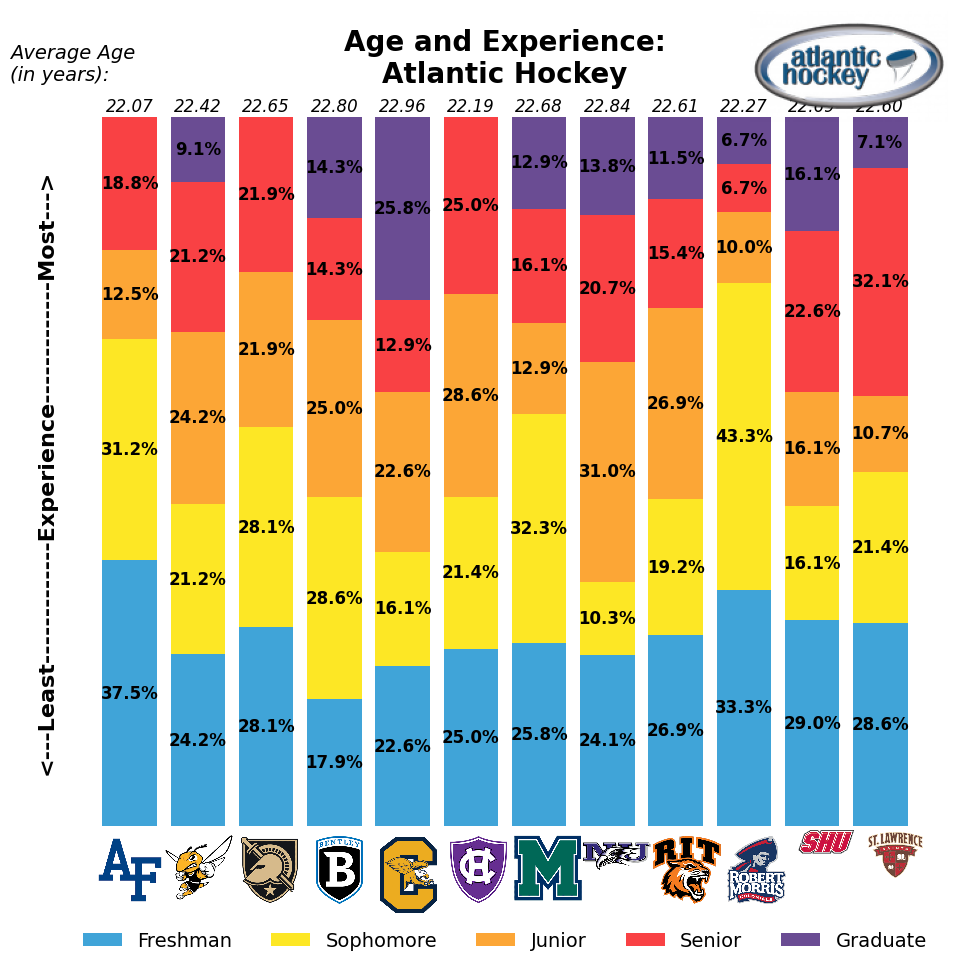

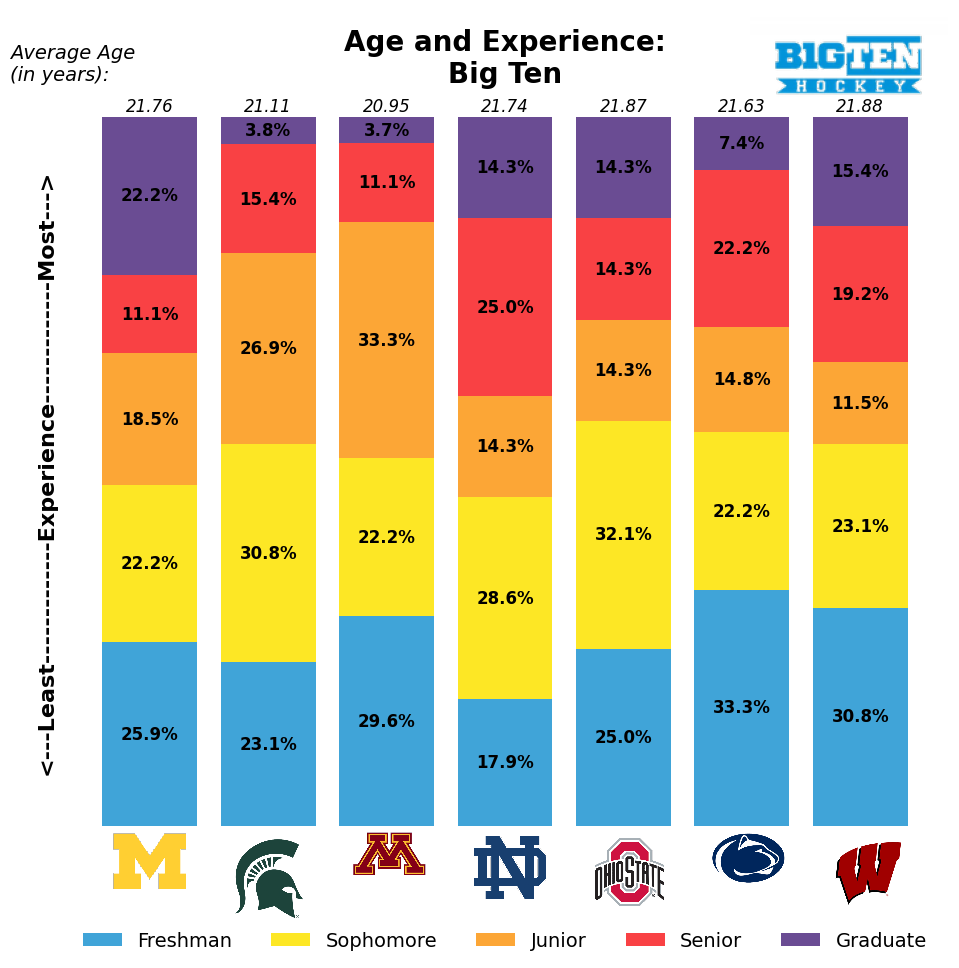

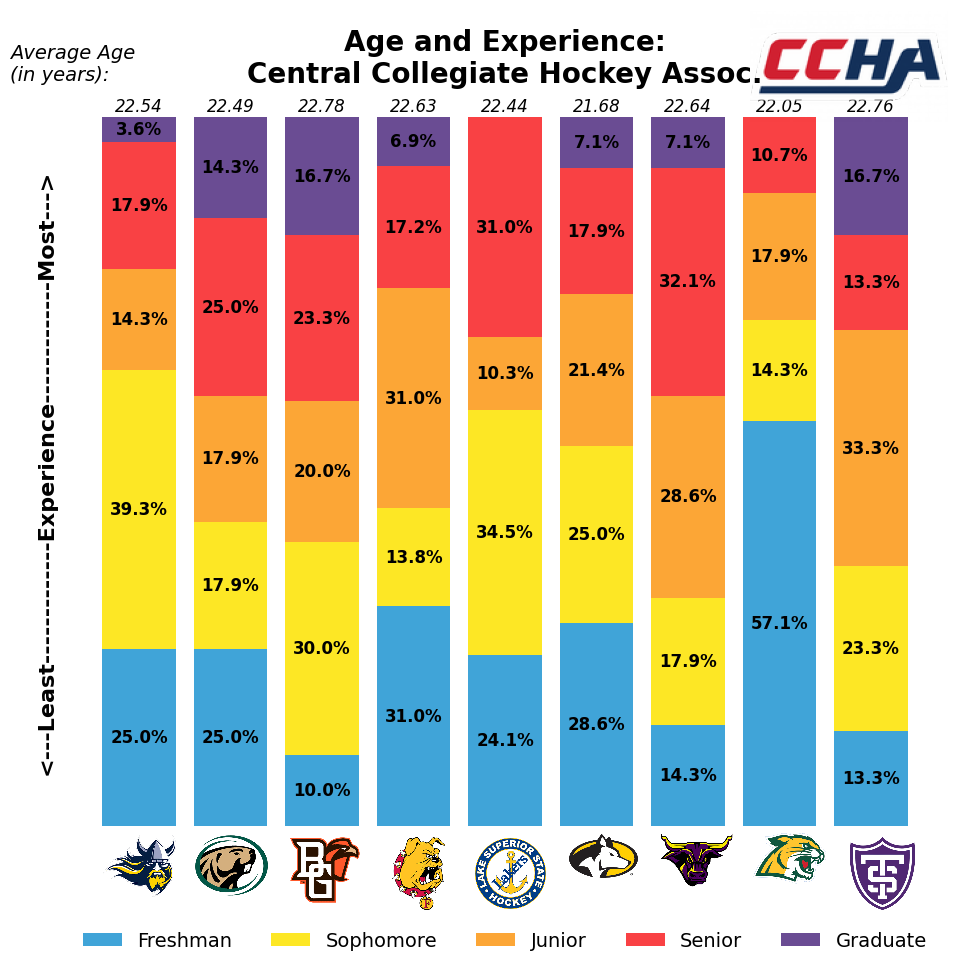

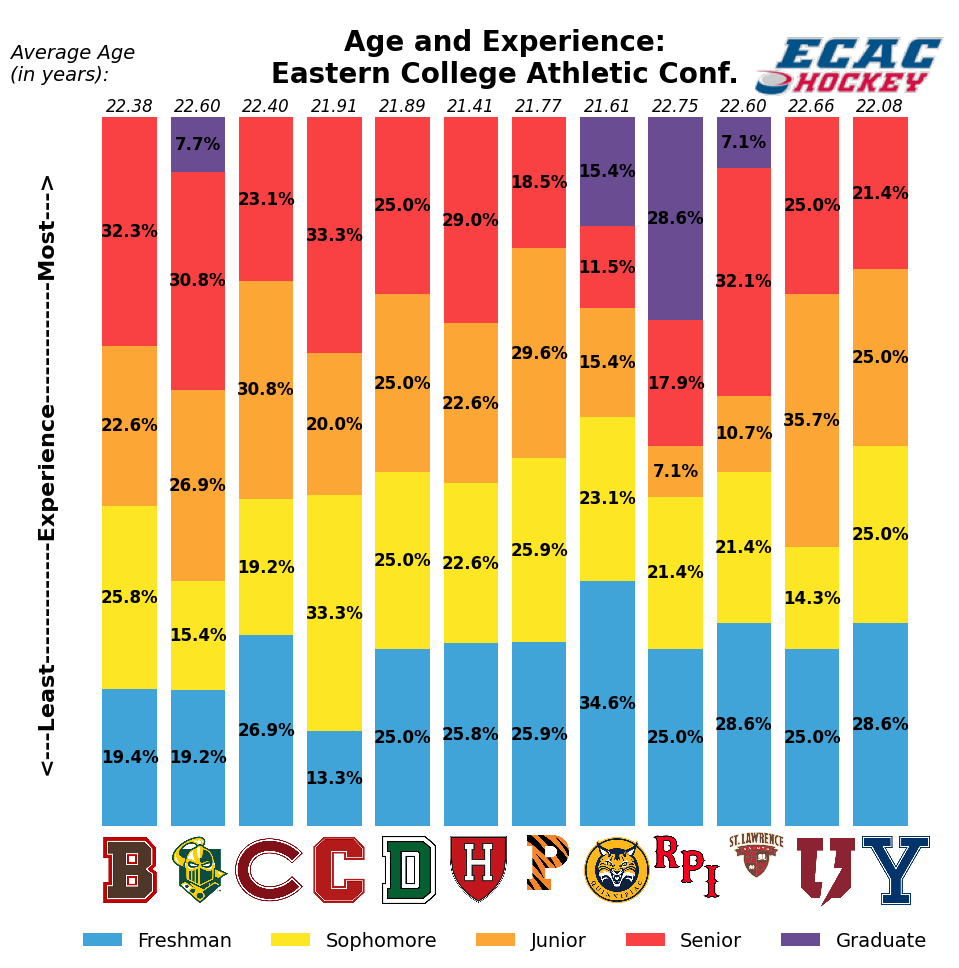

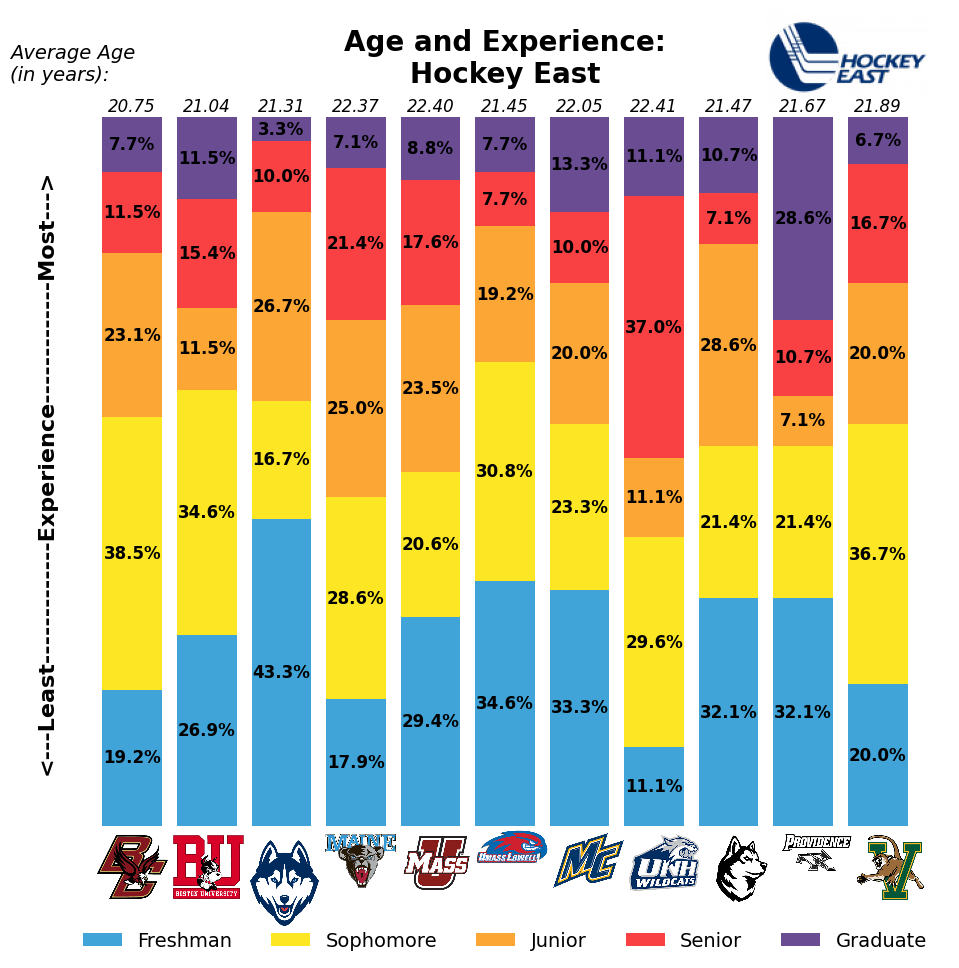

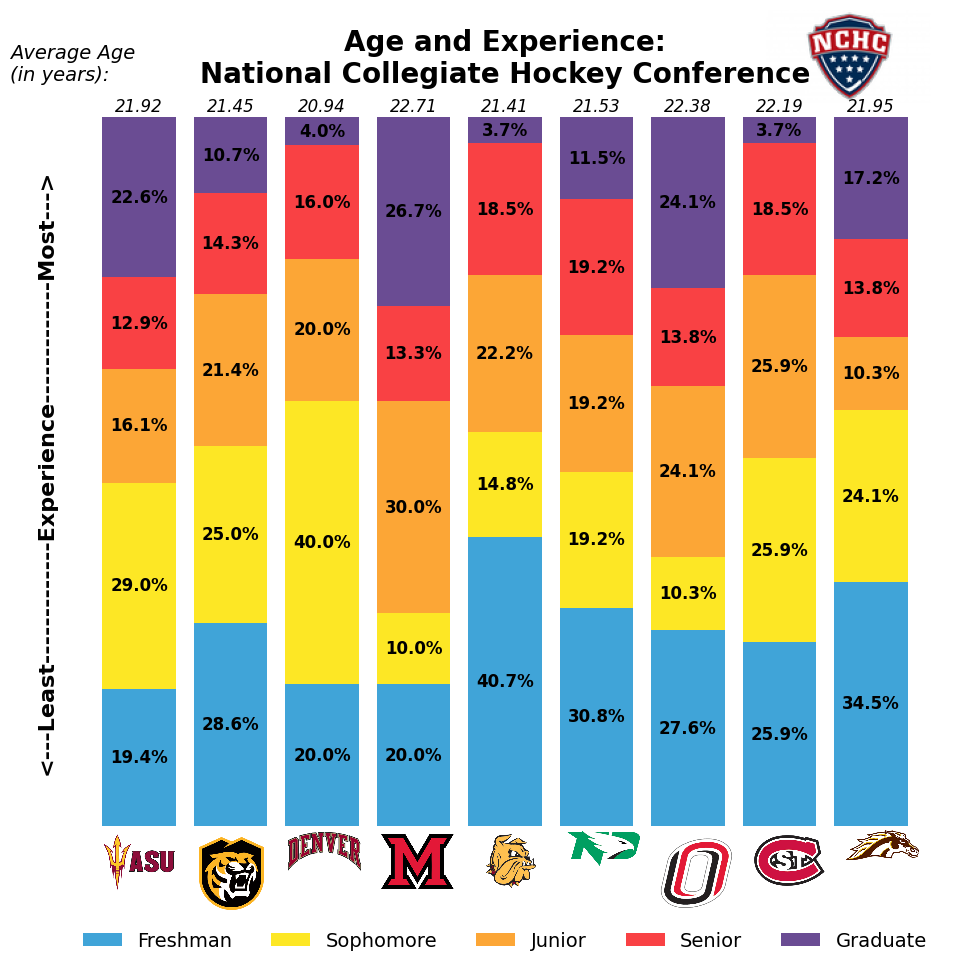

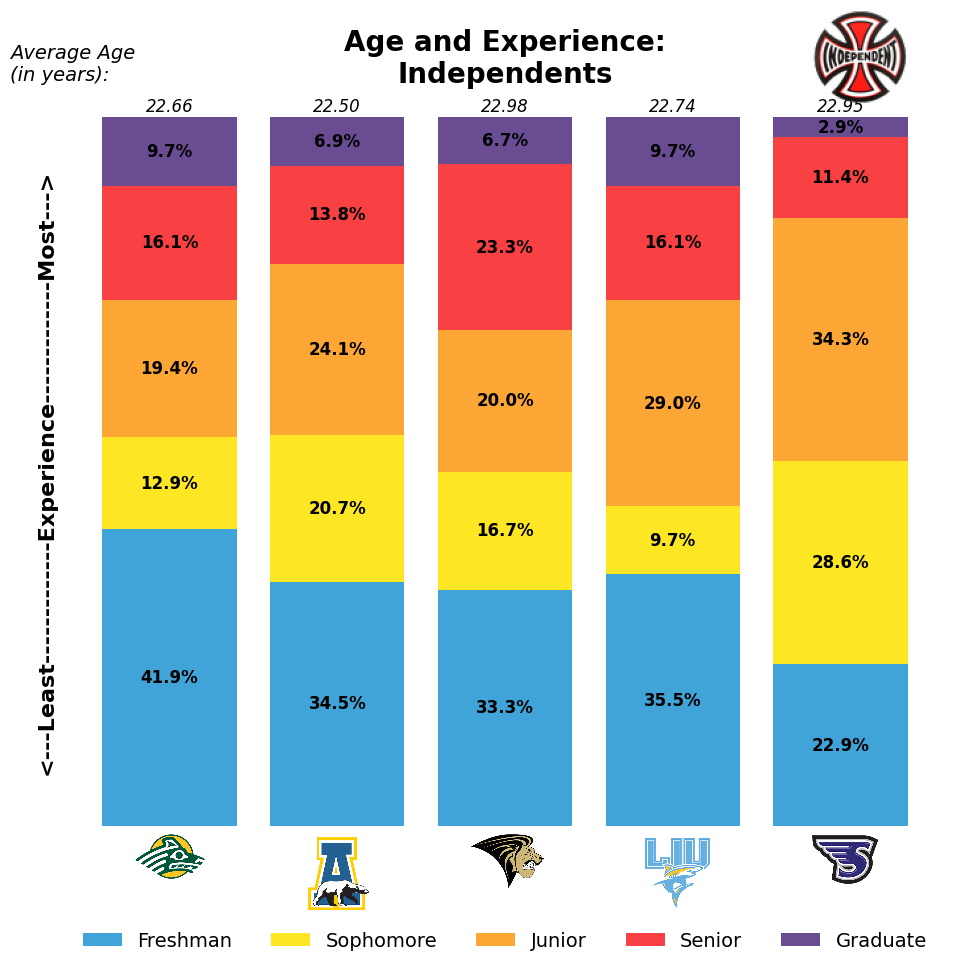

In [259]:
## Call the function for each conference
plot_team_ages_and_experience_with_logos(class_rank_count,atlantic, 'Atlantic Hockey', 'atlantic.png')
plot_team_ages_and_experience_with_logos(class_rank_count,big_ten, 'Big Ten', 'big_ten.png')
plot_team_ages_and_experience_with_logos(class_rank_count,ccha, 'Central Collegiate Hockey Assoc.', 'ccha.png')
plot_team_ages_and_experience_with_logos(class_rank_count,ecac, 'Eastern College Athletic Conf.', 'ecac.png')
plot_team_ages_and_experience_with_logos(class_rank_count,hockey_east, 'Hockey East', 'hockey_east_2.png')
plot_team_ages_and_experience_with_logos(class_rank_count,nchc, 'National Collegiate Hockey Conference', 'nchc_2.png')
plot_team_ages_and_experience_with_logos(class_rank_count,independents, 'Independents', 'independent_2.png')


### Create a Conference Level Plot

In [260]:
def aggregate_conference_data(df, team_names):
    """
    Aggregates the data for teams within a conference by computing the weighted 
    averages for the class proportions and the average age.
    
    Parameters:
    - df: DataFrame containing team names, ages, and class proportions.
    - team_names: List of team names to include in the aggregation.
    
    Returns:
    - A dictionary with average age and class proportions (Fr%, So%, Jr%, Sr%, Gr%).
    """
    # Filter the dataframe for the relevant teams
    filtered_df = df[df['Team'].isin(team_names)]
    
    # Calculate the total number of players per team to use as weights
    player_counts = filtered_df[['Fr%', 'So%', 'Jr%', 'Sr%', 'Gr%']].sum(axis=1)
    
    # Calculate weighted average age
    weighted_age = (filtered_df['Age'] * player_counts).sum() / player_counts.sum()
    
    # Calculate weighted class proportions
    weighted_proportions = (filtered_df[['Fr%', 'So%', 'Jr%', 'Sr%', 'Gr%']].multiply(player_counts, axis=0)).sum() / player_counts.sum()
    
    return {
        'Age': weighted_age,
        'Fr%': weighted_proportions['Fr%'],
        'So%': weighted_proportions['So%'],
        'Jr%': weighted_proportions['Jr%'],
        'Sr%': weighted_proportions['Sr%'],
        'Gr%': weighted_proportions['Gr%']
    }

def plot_all_conferences_vs_each_other(df, conferences):
    """
    Plots a stacked bar chart comparing class proportions and average ages across all conferences.
    
    Parameters:
    - df: DataFrame containing team names, ages, and class proportions.
    - conferences: Dictionary mapping conference names to lists of teams.
    """
    # Aggregate data for each conference
    aggregated_data = {}
    for conference, team_names in conferences.items():
        aggregated_data[conference] = aggregate_conference_data(df, team_names)
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=figure_size)
    
    # Set the title of the plot
    ax.set_title("Age and Experience by Conference [2024-25]", fontsize=20, weight='bold', pad=25)
    
    # Define the labels and colors for the stacked bars
    year_labels = ['Fr%', 'So%', 'Jr%', 'Sr%', 'Gr%']
    colors = ['#40A4D8', '#FDE725', '#FCA636', '#F94144', '#6A4C93']
    
    # Data for conferences
    conference_names = list(aggregated_data.keys())
    
    # Initialize bottom values for stacked bars
    bottom_values = [0] * len(conference_names)
    
    # Plot the stacked bars for each class proportion
    for i, year in enumerate(year_labels):
        proportions = [aggregated_data[conf][year] for conf in conference_names]
        bars = ax.bar(range(len(conference_names)), proportions, bottom=bottom_values, color=colors[i], label=year)
        bottom_values = [x + y for x, y in zip(bottom_values, proportions)]
        
        # Add text annotations for each bar
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2, f'{height:.1%}',
                        ha='center', va='center', fontsize=10, weight='bold', color='black')
    
    # Add the average age above each bar
    avg_ages = [aggregated_data[conf]['Age'] for conf in conference_names]
    for i, age in enumerate(avg_ages):
        ax.text(i, 1.02, f'{age:.2f}', ha='center', va='center', fontsize=12, color='black', fontstyle='italic')

    # Add a text annotation at the far right with datasource, rotated 90 degrees
    ax.text(
        1.05,           # x-coordinate (a bit outside the plot to the right)
        0.5,            # y-coordinate (center of the y-axis)
        'Data Source: College Hockey News | Data extracted on: 2024-9-11', 
        transform=ax.transAxes,  # Use axis coordinates (0,0 is bottom-left, 1,1 is top-right)
        fontsize=12,     # Set the font size
        ha='left',      # Horizontal alignment
        va='center',    # Vertical alignment
       rotation=90,
       font='Lucinda Sans Typewriter'    # Rotate the text 180 degrees
    )

    # Add "Average Age" label just above the average age numbers
    fig.text(0.005, 0.905, "Average Age \n(in years):", fontsize=14, ha='left', fontstyle = 'italic')

    # Remove y-axis ticks for cleaner look
    ax.set_yticks([])
    # Remover x-axis ticks
    ax.set_xticks([])
    
    # Customize the x-axis
    ax.set_xticks(range(len(conference_names)))
    ax.set_xticklabels(conference_names, fontsize=12, weight='bold', rotation=45, ha='right')
    
        # Remove the border (spines) around the plot
    for spine in ax.spines.values():
        spine.set_visible(False)
        
    # Map abbreviations to full words for the legend
    label_mapping = {
        'Fr%': 'Freshman',
        'So%': 'Sophomore',
        'Jr%': 'Junior',
        'Sr%': 'Senior',
        'Gr%': 'Graduate'
    }
    
    # Get current handles and labels from the plot
    handles, labels = ax.get_legend_handles_labels()
    
    # Replace short labels with full labels using the label_mapping dictionary
    labels = [label_mapping.get(label, label) for label in labels]
    
    # Customize the legend
    ax.legend(handles, labels, title='', fontsize=12, loc='lower center', ncol=len(year_labels), frameon=False, 
              bbox_to_anchor=(0.5, -0.2))
    
    # Set y-axis label
    ax.set_ylabel("<---Least-------------Experience-------------Most--->", fontsize=14, weight='bold')
    
    # Add conference logos below the bars as x-tick labels
    conference_logo_mapping = {
        'Atlantic': 'atlantic.png',
        'Big Ten': 'big_ten.png',
        'CCHA': 'ccha.png',
        'ECAC': 'ecac.png',
        'Hockey East': 'hockey_east.png',
        'NCHC': 'nchc.png',
        'Independents': 'independent.png'
    }

    # Define the standard size for logos (width, height)
    logo_size = (50, 50)  # Adjust the size as needed
    
    y_offset = 1.15  # Adjust y-offset for logo placement
    
    # Add logos for each conference while preserving aspect ratio
    for i, conference in enumerate(conference_names):
        if conference in conference_logo_mapping:
            file_path = os.path.join(logo_folder, 'conference', conference_logo_mapping[conference])
            
            # Open the image using PIL to preserve the aspect ratio
            img = Image.open(file_path)
            
            # Get the size of the image and calculate the zoom factor based on the height
            img_width, img_height = img.size
            aspect_ratio = img_width / img_height  # Aspect ratio of the image
            
            # Set a fixed height and calculate zoom to preserve aspect ratio
            desired_height = 50  # Adjust the height as needed
            zoom_factor = desired_height / img_height
            
            # Create the OffsetImage with the calculated zoom factor
            imagebox = OffsetImage(img, zoom=zoom_factor)
            
            # Adjust the positioning of logos below the x-axis
            ab = AnnotationBbox(imagebox, (i, 0), xycoords=('data', 'axes fraction'),
                                boxcoords="offset points", box_alignment=(0.5, y_offset), pad=0.1, frameon=False)
            ax.add_artist(ab)

    # Remove x-tick labels since we're using logos
    ax.set_xticks([])

    # Save and show plot
    plt.tight_layout()
    plt.savefig(f'{temp_folder}/all_conferences_comparison.png', dpi=300, bbox_inches='tight') ## Save To TEMP
    # Save To Output Folder
    plt.savefig(f'{img_folder}/all_conferences_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

# Dictionary of conference teams
conferences = {
    'Atlantic': ['Air Force', "American Intl", 'Army', 'Bentley', 'Canisius', 'Holy Cross', 'Mercyhurst', 
                 'Niagara', 'RIT', 'Robert Morris', 'Sacred Heart', 'St Lawrence'],
    'Big Ten': ['Michigan', 'Michigan State', 'Minnesota', 'Notre Dame', 'Ohio State', 'Penn State', 'Wisconsin'],
    'CCHA': ['Augustana', 'Bemidji State', 'Bowling Green', 'Ferris State', 'Lake Superior', 'Michigan Tech', 
             'Minnesota State', 'Northern Michigan', 'St Thomas'],
    'ECAC': ['Brown', 'Clarkson', 'Colgate', 'Cornell', 'Dartmouth', 'Harvard', 'Princeton', 'Quinnipiac',
             'Rensselaer', 'St Lawrence', 'Union', 'Yale'],
    'Hockey East': ['Boston College', 'Boston University', 'Connecticut', 'Maine', 'Massachusetts', 'Mass Lowell',
                    'Merrimack', 'New Hampshire', 'Northeastern', 'Providence', 'Vermont'],
    'NCHC': ['Arizona State', 'Colorado College', 'Denver', 'Miami', 'Minnesota Duluth', 'North Dakota', 'Omaha', 'St Cloud State',
             'Western Michigan'],
    'Independents': ['Alaska Anchorage', 'Alaska', 'Lindenwood', 'Long Island', 'Stonehill']
}



#### Output the Conference vs Conference Plot

findfont: Font family 'Lucinda Sans Typewriter' not found.
findfont: Font family 'Lucinda Sans Typewriter' not found.
findfont: Font family 'Lucinda Sans Typewriter' not found.
findfont: Font family 'Lucinda Sans Typewriter' not found.
findfont: Font family 'Lucinda Sans Typewriter' not found.
findfont: Font family 'Lucinda Sans Typewriter' not found.
findfont: Font family 'Lucinda Sans Typewriter' not found.
findfont: Font family 'Lucinda Sans Typewriter' not found.
findfont: Font family 'Lucinda Sans Typewriter' not found.
findfont: Font family 'Lucinda Sans Typewriter' not found.
findfont: Font family 'Lucinda Sans Typewriter' not found.
findfont: Font family 'Lucinda Sans Typewriter' not found.
findfont: Font family 'Lucinda Sans Typewriter' not found.
findfont: Font family 'Lucinda Sans Typewriter' not found.
findfont: Font family 'Lucinda Sans Typewriter' not found.
findfont: Font family 'Lucinda Sans Typewriter' not found.
findfont: Font family 'Lucinda Sans Typewriter' not foun

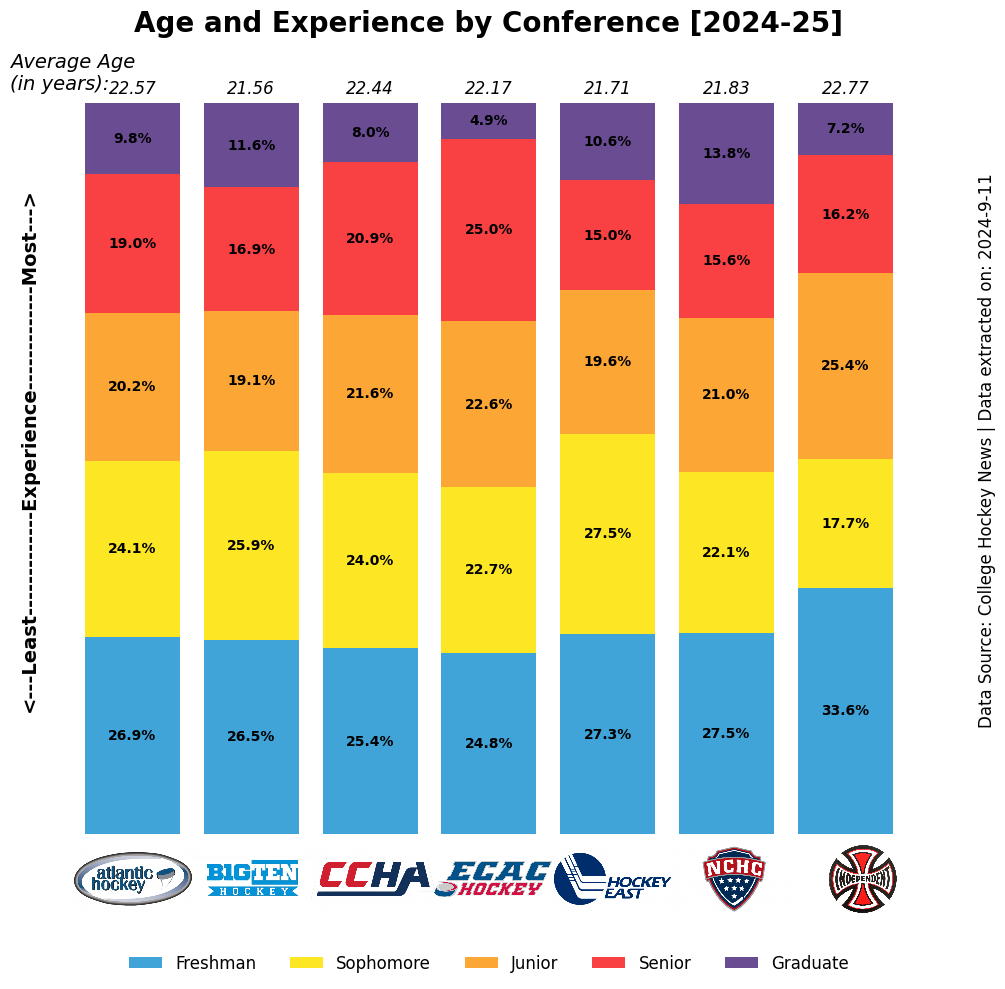

In [261]:

# Call the function to create the plot
plot_all_conferences_vs_each_other(class_rank_count, conferences)

In [262]:
roster_df.head()
class_rank_count.head()

,Team,Age,Fr,Fr%,So,So%,Jr,Jr%,Sr,Sr%,Gr,Gr%,Total
0,Air Force,22.072724,12,0.375000,10,0.312500,4,0.125000,6,0.187500,0,0.000000,32
1,Alaska,22.657175,13,0.419355,4,0.129032,6,0.193548,5,0.161290,3,0.096774,31
2,Alaska Anchorage,22.503569,10,0.344828,6,0.206897,7,0.241379,4,0.137931,2,0.068966,29
3,American Intl,22.417434,8,0.242424,7,0.212121,8,0.242424,7,0.212121,3,0.090909,33
4,Arizona State,21.923431,6,0.193548,9,0.290323,5,0.161290,4,0.129032,7,0.225806,31
